<a href="https://colab.research.google.com/github/sathasivamn/Project-3-602-Resume-Classification/blob/main/Project_3_Resume_Classification_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Install libraries
!pip install python-docx PyPDF2 nltk joblib scikit-learn matplotlib pandas seaborn streamlit
!apt-get update -y
!apt-get install -y libreoffice  # for .doc → .docx (optional if you have .doc files)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 253.0/253.0 kB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.6/232.6 kB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.0/9.0 MB 72.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 94.8 MB/s eta 0:00:00
Get:1 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Hit:2 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:3 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:4 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Hit:5 https://cli.github.com/packages stable InRelease
Get:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:7 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease [18.1 kB]
Hit:8 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRele

In [2]:
# Imports and NLTK setup
import os
import zipfile
from pathlib import Path

import pandas as pd
import numpy as np

from docx import Document
import PyPDF2

import nltk
from nltk.corpus import stopwords
import re

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, f1_score, classification_report, confusion_matrix
)

import matplotlib.pyplot as plt
import seaborn as sns

import joblib

In [3]:
#Download NLTK data:
nltk.download('stopwords')
nltk.download('punkt')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


# Upload and extract dataset zip


In [4]:
from google.colab import files

uploaded = files.upload()  # upload resume_classification.zip

ZIP_NAME = "resume_classification.zip"   # change if your zip has a different name
EXTRACT_DIR = "/content/data"
os.makedirs(EXTRACT_DIR, exist_ok=True)

if ZIP_NAME in uploaded:
    with zipfile.ZipFile(ZIP_NAME, "r") as z:
        z.extractall(EXTRACT_DIR)
    print("Zip extracted to:", EXTRACT_DIR)
else:
    raise FileNotFoundError("Upload your dataset zip using files.upload()")

Saving resume_classification.zip to resume_classification.zip
Zip extracted to: /content/data


In [5]:
# (Optional) Convert .doc → .docx with LibreOffice
base = Path(EXTRACT_DIR)

doc_files = list(base.rglob("*.doc"))
print("Found .doc files:", len(doc_files))

for doc in doc_files:
    outdir = str(doc.parent)
    cmd = f'soffice --headless --convert-to docx "{doc}" --outdir "{outdir}"'
    os.system(cmd)

print("DOC → DOCX conversion completed.")

Found .doc files: 26
DOC → DOCX conversion completed.


In [6]:
# Define file readers (DOCX + PDF)
def read_docx(path):
    try:
        d = Document(path)
        return "\n".join(p.text for p in d.paragraphs)
    except Exception as e:
        # print("DOCX read error:", e)
        return ""

def read_pdf(path):
    try:
        r = PyPDF2.PdfReader(path)
        all_text = ""
        for p in r.pages:
            all_text += p.extract_text() or ""
        return all_text
    except Exception as e:
        # print("PDF read error:", e)
        return ""

In [7]:
# Build the DataFrame df
rows = []
skipped = []

all_files = [p for p in base.rglob("*") if p.is_file()]

for p in all_files:
    ext = p.suffix.lower()
    if ext not in [".pdf", ".docx"]:
        continue  # ignore other file types

    # folder name is label (e.g. 'DataScience', 'HR')
    label = p.parts[-2]

    if ext == ".docx":
        text = read_docx(str(p))
    elif ext == ".pdf":
        text = read_pdf(str(p))
    else:
        text = ""

    if text.strip():
        rows.append({
            "filename": p.name,
            "filepath": str(p),
            "label": label,
            "text": text
        })
    else:
        skipped.append(str(p))

df = pd.DataFrame(rows)

print(" DataFrame 'df' CREATED SUCCESSFULLY ")
print("Total Documents:", len(df))
print("Skipped Files:", len(skipped))
print("Columns:", df.columns.tolist())
df.head()

 DataFrame 'df' CREATED SUCCESSFULLY 
Total Documents: 79
Skipped Files: 0
Columns: ['filename', 'filepath', 'label', 'text']


,filename,filepath,label,text
0,React JS Developer_KotaniDurgaprasad[3_1] (1)-...,/content/data/Resume_C/React_Developer/React J...,React_Developer,Kotani Durga Prasad\n\n\nObjective:\n\nAspiran...
1,Reactjs Developer_Ranga Gaganam_Musquare Techn...,/content/data/Resume_C/React_Developer/Reactjs...,React_Developer,Ranga Gaganam \n \n \nHaving 1+ years of succ...
2,React Developer_Sarala Madasu-converted.docx,/content/data/Resume_C/React_Developer/React D...,React_Developer,"\n\n 204,Sri geethika prestige,road number 10..."
3,React Developer_Haripriya.docx,/content/data/Resume_C/React_Developer/React D...,React_Developer,HARIPRIYA BATTINA \nExperience as UI Developer...
4,React Developer_Deepakreddy.docx,/content/data/Resume_C/React_Developer/React D...,React_Developer,Kanumuru Deepak Reddy\n\n\n\nCAREER OBJECTIVE:...


Columns: ['filename', 'filepath', 'label', 'text']

Label distribution:
label
React_Developer    24
workday            21
Peoplesoft         20
SQL_Developer      14
Name: count, dtype: int64


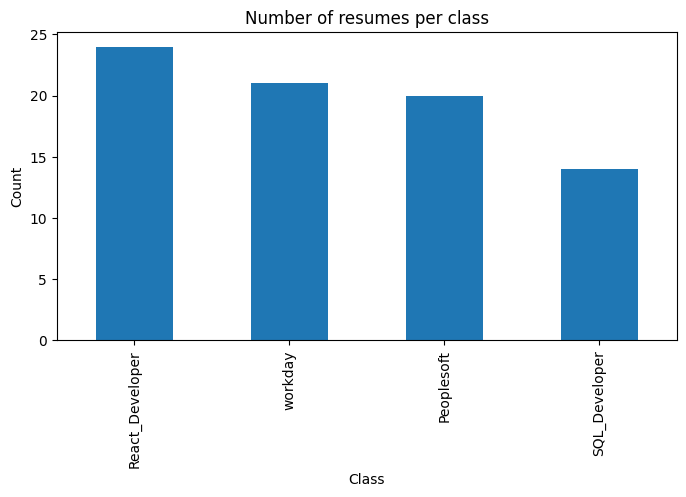

In [8]:
# EDA – Basic Exploratory Analysis
print("Columns:", df.columns.tolist())
print("\nLabel distribution:")
print(df['label'].value_counts())

plt.figure(figsize=(8,4))
df['label'].value_counts().plot(kind='bar')
plt.title("Number of resumes per class")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()

         char_count  word_count_raw
count     79.000000       79.000000
mean    4690.620253      626.227848
std     3125.606798      423.819415
min      162.000000       19.000000
25%     2740.000000      350.500000
50%     3708.000000      515.000000
75%     6156.500000      800.500000
max    17654.000000     2458.000000


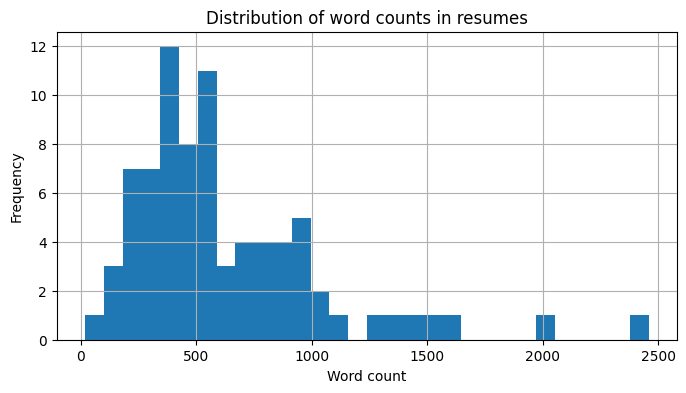

In [9]:
# Text length stats
df['char_count'] = df['text'].apply(len)
df['word_count_raw'] = df['text'].apply(lambda x: len(str(x).split()))

print(df[['char_count', 'word_count_raw']].describe())

plt.figure(figsize=(8,4))
df['word_count_raw'].hist(bins=30)
plt.title("Distribution of word counts in resumes")
plt.xlabel("Word count")
plt.ylabel("Frequency")
plt.show()

In [10]:
# Quick sample
df[['filename', 'label']].head(10)

,filename,label
0,React JS Developer_KotaniDurgaprasad[3_1] (1)-...,React_Developer
1,Reactjs Developer_Ranga Gaganam_Musquare Techn...,React_Developer
2,React Developer_Sarala Madasu-converted.docx,React_Developer
3,React Developer_Haripriya.docx,React_Developer
4,React Developer_Deepakreddy.docx,React_Developer
5,React Developer_Naveen sadhu.docx,React_Developer
6,React Developer_Pragnya.docx,React_Developer
7,React JS Developer_AnjaniPriyadarshini.docx,React_Developer
8,Reactjs Developer_MD Khizaruddin Rauf _Musquar...,React_Developer
9,Reactjs Developer_Pranish Sonone_Musquare Tech...,React_Developer


In [11]:
# one full resume text sample:
sample_row = df.iloc[0]
print("Filename:", sample_row['filename'])
print("Label:", sample_row['label'])
print("--- Text snippet ---")
print(sample_row['text'][:1000])

Filename: React JS Developer_KotaniDurgaprasad[3_1] (1)-converted.docx
Label: React_Developer
--- Text snippet ---
Kotani Durga Prasad


Objective:

Aspirant for a position in an organization where I can contribute my skills for organization’s success and synchronize with new technologies while being resourceful, innovative and flexible.

Professional Summary:
3.1 years of experience as a Software Engineer.
Highly creative web designer and front end developer with experience of working on a diverse range of projects from small business websites to large scale websites with a global user base.
Excellent knowledge in HTML, HTML5, CSS3, Bootstrap frameworks. Strong hands on experience in hand coding web technologies.
Good Knowledge in Designing & Developing the Web pages based on SEO (Search Engine Optimization), W3C Standards and Cross-Browser Compatibility.
Very good knowledge in client side programming with JavaScript, jQuery. Working knowledge in React JS.
Experience in developing ful

In [12]:
# Text cleaning functions
# Use the same cleaning strategy for training and Streamlit prediction.
def clean_text_basic(s):
    s = str(s).lower()
    s = re.sub(r'\s+', ' ', s)            # collapse whitespace
    s = re.sub(r'http\S+', '', s)         # remove urls
    s = re.sub(r'\@\w+', '', s)           # remove @mentions
    s = re.sub(r'[^a-z0-9\s]', ' ', s)    # keep alphanumeric + space
    s = re.sub(r'\s+', ' ', s).strip()
    return s

def remove_stopwords(s):
    tokens = s.split()
    tokens = [t for t in tokens if t not in stop_words]
    return " ".join(tokens)

df['clean_text'] = df['text'].apply(clean_text_basic)
df['clean_text_nostop'] = df['clean_text'].apply(remove_stopwords)

df['char_count_clean'] = df['clean_text'].apply(len)
df['word_count_clean'] = df['clean_text'].apply(lambda x: len(x.split()))

print(df[['char_count_clean', 'word_count_clean']].describe())

       char_count_clean  word_count_clean
count         79.000000         79.000000
mean        4324.063291        633.493671
std         2987.550310        431.091217
min          137.000000         20.000000
25%         2392.500000        357.000000
50%         3511.000000        537.000000
75%         5709.000000        833.500000
max        16975.000000       2462.000000


In [13]:
# Train/test split
X = df['clean_text']       # or 'clean_text_nostop'
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Train size:", len(X_train))
print("Test size:", len(X_test))

Train size: 63
Test size: 16


In [14]:
# Train & evaluate multiple models
def train_and_eval(clf, X_train, y_train, X_test, y_test, name=None):
    pipe = Pipeline([
        ('tfidf', TfidfVectorizer(
            ngram_range=(1,2),
            max_df=0.95,
            min_df=2,
            max_features=15000
        )),
        ('clf', clf)
    ])

    pipe.fit(X_train, y_train)
    preds = pipe.predict(X_test)

    acc = accuracy_score(y_test, preds)
    f1 = f1_score(y_test, preds, average='macro')

    print(f"\n--- {name or clf.__class__.__name__} ---")
    print("Accuracy :", acc)
    print("Macro F1 :", f1)
    print(classification_report(y_test, preds))

    return pipe, acc, f1, preds

models = {
    'LogisticRegression': LogisticRegression(max_iter=2000),
    'MultinomialNB': MultinomialNB(),
    'LinearSVC': LinearSVC(max_iter=20000),
    'RandomForest': RandomForestClassifier(n_estimators=200, random_state=42)
}

results = []
pipelines = {}

for name, clf in models.items():
    pipe, acc, f1, preds = train_and_eval(clf, X_train, y_train, X_test, y_test, name=name)
    results.append({'model': name, 'accuracy': acc, 'f1_macro': f1})
    pipelines[name] = pipe

res_df = pd.DataFrame(results).sort_values('f1_macro', ascending=False).reset_index(drop=True)
res_df


--- LogisticRegression ---
Accuracy : 1.0
Macro F1 : 1.0
                 precision    recall  f1-score   support

     Peoplesoft       1.00      1.00      1.00         4
React_Developer       1.00      1.00      1.00         5
  SQL_Developer       1.00      1.00      1.00         3
        workday       1.00      1.00      1.00         4

       accuracy                           1.00        16
      macro avg       1.00      1.00      1.00        16
   weighted avg       1.00      1.00      1.00        16


--- MultinomialNB ---
Accuracy : 1.0
Macro F1 : 1.0
                 precision    recall  f1-score   support

     Peoplesoft       1.00      1.00      1.00         4
React_Developer       1.00      1.00      1.00         5
  SQL_Developer       1.00      1.00      1.00         3
        workday       1.00      1.00      1.00         4

       accuracy                           1.00        16
      macro avg       1.00      1.00      1.00        16
   weighted avg       1.00   

,model,accuracy,f1_macro
0,LogisticRegression,1.0,1.0
1,MultinomialNB,1.0,1.0
2,LinearSVC,1.0,1.0
3,RandomForest,1.0,1.0


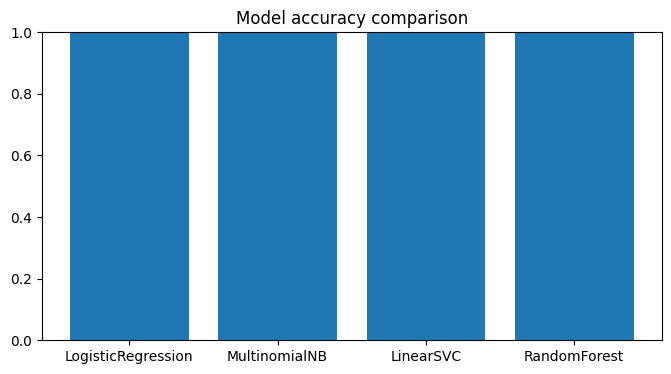

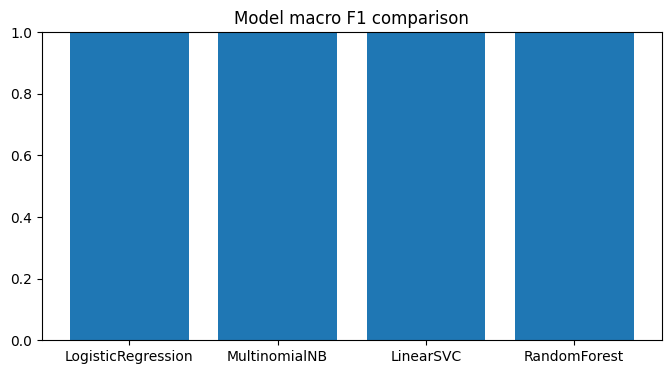

In [15]:
# Plot comparison + confusion matrix for best model
plt.figure(figsize=(8,4))
plt.bar(res_df['model'], res_df['accuracy'])
plt.title('Model accuracy comparison')
plt.ylim(0,1)
plt.show()

plt.figure(figsize=(8,4))
plt.bar(res_df['model'], res_df['f1_macro'])
plt.title('Model macro F1 comparison')
plt.ylim(0,1)
plt.show()

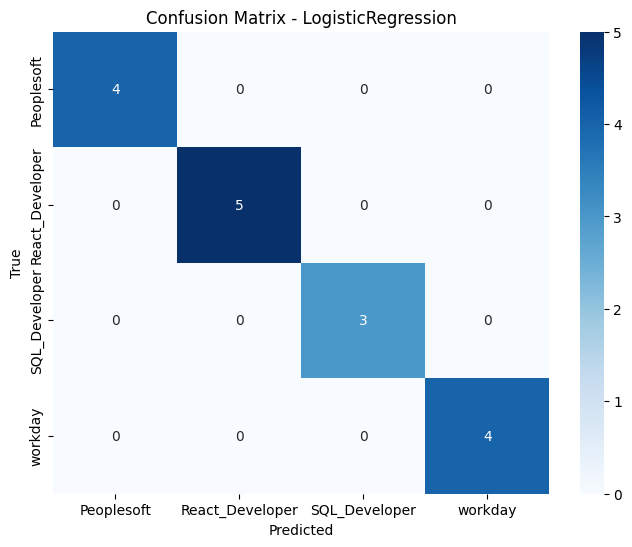

In [16]:
# Confusion matrix:
best_model_name = res_df.loc[0, 'model']
best_pipe = pipelines[best_model_name]

y_pred = best_pipe.predict(X_test)
cm = confusion_matrix(y_test, y_pred, labels=best_pipe.classes_)

fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=best_pipe.classes_,
            yticklabels=best_pipe.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title(f'Confusion Matrix - {best_model_name}')
plt.show()

In [17]:
# Save the best model for deployment
pickle_filename = 'best_model.pkl'
joblib.dump(best_pipe, pickle_filename)
print(f"The best model ('{best_model_name}') has been saved to '{pickle_filename}'")

The best model ('LogisticRegression') has been saved to 'best_model.pkl'


In [18]:
# Streamlit App (app.py)
!pip install python-docx PyPDF2 nltk joblib scikit-learn matplotlib pandas seaborn streamlit
import streamlit as st
import joblib
import io
import re

from docx import Document
import PyPDF2

import nltk
from nltk.corpus import stopwords

# Ensure NLTK stopwords are available
try:
    stop_words = set(stopwords.words('english'))
except LookupError:
    nltk.download('stopwords')
    stop_words = set(stopwords.words('english'))

# ---------------------------
# Text cleaning (same as training)
# ---------------------------

def clean_text_basic(s):
    s = str(s).lower()
    s = re.sub(r'\s+', ' ', s)            # collapse whitespace
    s = re.sub(r'http\S+', '', s)         # remove urls
    s = re.sub(r'\@\w+', '', s)           # remove @mentions
    s = re.sub(r'[^a-z0-9\s]', ' ', s)    # keep alphanumeric + space
    s = re.sub(r'\s+', ' ', s).strip()
    return s

def remove_stopwords(s):
    tokens = s.split()
    tokens = [t for t in tokens if t not in stop_words]
    return " ".join(tokens)

def preprocess_text(s):
    s = clean_text_basic(s)
    s = remove_stopwords(s)
    return s

# ---------------------------
# File readers for uploaded resumes
# ---------------------------

def read_docx_file(file_bytes):
    file_stream = io.BytesIO(file_bytes)
    doc = Document(file_stream)
    return "\n".join(p.text for p in doc.paragraphs)

def read_pdf_file(file_bytes):
    file_stream = io.BytesIO(file_bytes)
    reader = PyPDF2.PdfReader(file_stream)
    text = ""
    for page in reader.pages:
        text += page.extract_text() or ""
    return text

def read_txt_file(file_bytes):
    return file_bytes.decode("utf-8", errors="ignore")

def extract_text_from_upload(uploaded_file):
    if uploaded_file is None:
        return ""

    file_bytes = uploaded_file.read()
    name = uploaded_file.name.lower()

    if name.endswith(".docx"):
        return read_docx_file(file_bytes)
    elif name.endswith(".pdf"):
        return read_pdf_file(file_bytes)
    elif name.endswith(".txt"):
        return read_txt_file(file_bytes)
    else:
        raise ValueError("Unsupported file type. Please upload .pdf, .docx, or .txt")

# ---------------------------
# Load model
# ---------------------------

@st.cache_resource
def load_model():
    model = joblib.load("best_model.pkl")
    return model

model = load_model()

# ---------------------------
# Streamlit UI
# ---------------------------

st.title("📄 Resume Classification App")
st.write(
    "Upload a resume (.pdf / .docx / .txt) and the model will predict the job category."
)

uploaded_file = st.file_uploader(
    "Upload your resume file",
    type=["pdf", "docx", "txt"]
)

if uploaded_file is not None:
    st.write("**File uploaded:**", uploaded_file.name)

    if st.button("Predict Category"):
        try:
            raw_text = extract_text_from_upload(uploaded_file)

            if not raw_text.strip():
                st.error("Could not extract any text from the file.")
            else:
                st.subheader("Extracted Text (first 1000 chars)")
                st.text(raw_text[:1000])

                processed_text = preprocess_text(raw_text)
                pred_label = model.predict([processed_text])[0]
                st.subheader("Predicted Category")
                st.success(pred_label)

                # Show probabilities if available
                clf = model.named_steps.get('clf', None)
                if clf is not None and hasattr(clf, "predict_proba"):
                    probs = clf.predict_proba(
                        model.named_steps['tfidf'].transform([processed_text])
                    )[0]
                    classes = clf.classes_

                    st.subheader("Prediction Probabilities")
                    prob_table = {cls: float(p) for cls, p in zip(classes, probs)}
                    st.write(prob_table)

        except Exception as e:
            st.error(f"Error processing file: {e}")

2025-12-04 16:13:00.448 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-12-04 16:13:00.706 
  command:

    streamlit run /usr/local/lib/python3.12/dist-packages/colab_kernel_launcher.py [ARGUMENTS]
2025-12-04 16:13:00.707 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-12-04 16:13:00.708 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-12-04 16:13:00.709 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-12-04 16:13:00.759 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-12-04 16:13:00.760 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-12-04 16:13:00.761 Thread 'MainThread': mi